In [1]:
from IPython import display

from utils import Logger

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets

from pytictoc import TicToc
import datetime

import numpy as np
import matplotlib.pyplot as plt

import csv

In [2]:
%config InlineBackend.figure_format = 'svg'

params = {'figure.figsize': [5, 5],
    'axes.labelsize': 20,
    'axes.titlesize':24,
    'font.size': 20,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
}
plt.rcParams.update(params)

In [3]:
DATA_FOLDER = './torch_data/DCGAN/MNIST'

In [4]:
CONTINUE_TRAINING = False

In [5]:
N_RUN = 1

In [6]:
# Number of epochs
num_epochs = 200

## Load Data

In [7]:
def mnist_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [8]:
data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

## Networks

In [9]:
if CONTINUE_TRAINING:
    pretrained_model_D = "data/models/DCGAN/MNIST/D_epoch_" + str((N_RUN-1) * num_epochs - 1)
    pretrained_model_G = "data/models/DCGAN/MNIST/G_epoch_" + str((N_RUN-1) * num_epochs - 1)

In [10]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [11]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [12]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [13]:
use_cuda = True

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [14]:
# Create Network instances and init weights
generator = GenerativeNet().to(device)
generator.apply(init_weights)
if CONTINUE_TRAINING:
    discriminator.load_state_dict(torch.load(pretrained_model_D, map_location='cuda'))

discriminator = DiscriminativeNet().to(device)
discriminator.apply(init_weights)
if CONTINUE_TRAINING:
    generator.load_state_dict(torch.load(pretrained_model_G, map_location='cuda'))

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

/home/tito/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU1 GeForce GT 640 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


## Optimization

In [15]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

## Training

In [16]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [17]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [18]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

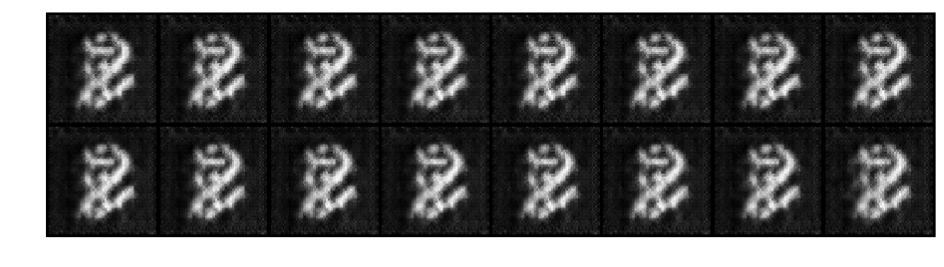

Epoch: [61/200], Batch Num: [100/600]
Discriminator Loss: 54.8659, Generator Loss: 60.4299
D(x): 0.0000, D(G(z)): 0.0000
Epoch 61, Batch 100 took 	 121.727290 seconds.
Until now:	 12:29:41.499106


KeyboardInterrupt: 

In [19]:
%%time

t = TicToc()

t.tic()

TV = 0
timing = []

logger = Logger(model_name='DCGAN', data_name='MNIST')

d_error_epochs = []
g_error_epochs = []
d_pred_real_epochs = []
d_pred_fake_epochs = []

for epoch in range((N_RUN-1) * num_epochs, (N_RUN-1) * num_epochs + num_epochs):
    
    d_error_batches = []
    g_error_batches = []
    d_pred_real_batches = []
    d_pred_fake_batches = []
    
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs * N_RUN, n_batch, num_batches,
                float(d_error), float(g_error), d_pred_real, d_pred_fake
            )
            
            TV = TV + t.tocvalue()
            t.toc('Epoch %d, Batch %d took \t' % (epoch, n_batch), restart=True)
            print("Until now:\t {:0>8}".format(str(datetime.timedelta(seconds=TV))))
            
            timing.append(TV)
            
        d_error_batches.append(d_error.tolist())
        g_error_batches.append(g_error.tolist())
        d_pred_real_batches.append(d_pred_real.data.tolist())
        d_pred_fake_batches.append(d_pred_fake.data.tolist())
        
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
    
    d_error_epochs.append(d_error_batches)
    g_error_epochs.append(g_error_batches)
    d_pred_real_epochs.append(d_pred_real_batches)
    d_pred_fake_epochs.append(d_pred_fake_batches)

In [20]:
d_error_batches_array = np.array(d_error_batches)
d_error_batches_array.shape

(148,)

In [21]:
d_error_epochs_array = np.array(d_error_epochs)
d_error_epochs_array.shape

(61, 600)

In [22]:
g_error_batches_array = np.array(g_error_batches)
g_error_batches_array.shape

(148,)

In [23]:
g_error_epochs_array = np.array(g_error_epochs)
g_error_epochs_array.shape

(61, 600)

In [24]:
g_error_epochs_array = np.array(g_error_epochs)
g_error_epochs_array.shape

(61, 600)

In [25]:
d_pred_real_epochs_array = np.array(d_pred_real_epochs)
d_pred_real_epochs_array.shape

(61, 600, 100, 1)

In [26]:
new_d_pred_real_epochs_array = d_pred_real_epochs_array.reshape((200, 600, 100))
new_d_pred_fake_epochs_array = d_pred_fake_epochs_array.reshape((200, 600, 100))

prob_real = []
for i in new_d_pred_real_epochs_array:
    tmpReal = []
    for j in i:
        tmpReal.append(j[0])
    prob_real.append(np.mean(tmpReal))
prob_real = np.array(prob_real)

prob_fake = []
for i in new_d_pred_fake_epochs_array:
    tmpFake = []
    for j in i:
        tmpFake.append(j[0])
    prob_fake.append(np.mean(tmpFake))
prob_fake = np.array(prob_fake)

ValueError: cannot reshape array of size 3660000 into shape (200,600,100)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(prob_real.shape[0] + ((N_RUN-2) * num_epochs), prob_real.shape[0] + ((N_RUN-1) * num_epochs) - 1,prob_real.shape[0]), prob_real, LineWidth=3, label='real')
plt.plot(np.linspace(prob_fake.shape[0] + ((N_RUN-2) * num_epochs), prob_fake.shape[0] + ((N_RUN-1) * num_epochs) - 1,prob_fake.shape[0]), prob_fake, LineWidth=3, label='fake')
plt.xlabel('Epoch')
plt.ylabel('Probability')
#plt.xlim(200, 400)
#plt.ylim(0,1)
#plt.xticks([200, 250, 300, 350, 400])
#plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid(True)
plt.legend()
plt.savefig('dcgan_uncertainty_' + str(N_RUN * 200) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_pred_fake_epochs_array = np.array(d_pred_fake_epochs)
d_pred_fake_epochs_array.shape

In [ ]:
# d_pred_real_array = np.array(d_pred_real.tolist())
# d_pred_real_array = d_pred_real_array.reshape(d_pred_real_array.shape[0])

# d_pred_fake_array = np.array(d_pred_fake.tolist())
# d_pred_fake_array = d_pred_fake_array.reshape(d_pred_fake_array.shape[0])

In [ ]:
csvfile = "dcgan_d_error_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(d_error_epochs)
    
csvfile = "dcgan_g_error_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(g_error_epochs)
    
csvfile = "dcgan_d_pred_real_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_real:
        writer.writerow([val])
        
csvfile = "dcgan_d_pred_fake_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_fake:
        writer.writerow([val])

In [ ]:
d_error_epochs_array = np.array(d_error_epochs)
new_d_error_epochs_array = np.array([np.mean(d_error_epochs_array[i,:]) for i in range(d_error_epochs_array.shape[0])])

g_error_epochs_array = np.array(g_error_epochs)
new_g_error_epochs_array = np.array([np.mean(g_error_epochs_array[i,:]) for i in range(g_error_epochs_array.shape[0])])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(d_error_epochs_array.shape[0]), new_d_error_epochs_array, LineWidth=3, label='discriminator')
plt.plot(range(g_error_epochs_array.shape[0]), new_g_error_epochs_array, LineWidth=3, label='generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(0, 200)
#plt.ylim(0, 4)
plt.grid(True)
plt.legend()
plt.savefig('dcgan_loss_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(range(d_pred_real_array.shape[0]), d_pred_real_array, LineWidth=3, label='real')
# plt.plot(range(d_pred_fake_array.shape[0]), d_pred_fake_array, LineWidth=3, label='fake')
# plt.xlabel('Epoch')
# plt.ylabel('Uncertainty')
# plt.xlim(0,200)
# plt.grid(True)
# plt.legend()
# plt.savefig('dcgan_uncertainty_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
new_timing = []
new_timing_mean = []
new_timing_sum = []

for i in range(int(len(timing)/6)):
    new_timing.append(timing[i:i+6])
    new_timing_mean.append(np.mean(timing[i:i+6]))
    new_timing_sum.append(np.sum(timing[i:i+6]))
    
new_timing = np.array(new_timing)
new_timing_mean = np.array(new_timing_mean)
new_timing_sum = np.array(new_timing_sum)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(new_timing_mean.shape[0]), new_timing_mean, LineWidth=3, label='Mean Epoch Time')
plt.plot(range(new_timing_sum.shape[0]), new_timing_sum, LineWidth=3, label='Total Epoch Time' )
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Processing Time [seconds]')
#plt.xlim(0,200)
#plt.ylim(0, 12000)
#plt.xticks([0, 50, 100, 150, 200])
#plt.yticks([0, 4000, 8000, 12000])
plt.grid(True)
plt.savefig('dcgan_timing_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
T = [0]
T_tmp = [new_timing_mean[i+1] - new_timing_mean[i] for i in range(new_timing_mean.shape[0]-1)]
T.extend(T_tmp)
T = np.array(T)

csvfile = "T_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in T:
        writer.writerow([val])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(T.shape[0]), T, LineWidth=3, label='Processing Time')
plt.hlines(np.mean(T), xmin=0, xmax=200, LineWidth=3, color='r', label='Mean (%.2f s)'%np.mean(T))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Processing Time [s]')
#plt.xlim(0,200)
#plt.ylim(0, 12)
#plt.xticks([0, 50, 100, 150, 200])
#plt.yticks([0, 2, 4, 6, 8, 10, 12])
plt.grid(True)
plt.savefig('dcgan_T_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()